### Libraries Loading

In [207]:
import pandas as pd
import numpy as np

In [290]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn import linear_model

#### Read Data File

In [209]:
# Reading data into a DataFrame
df_meas = pd.read_csv('data/measurements.csv')
display(df_meas.head())
display(df_meas.tail())
df_meas.shape

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
383,16,"3,7",39,"24,5",18,NaN,SP98,0,0,0,NaN,NaN
384,"16,1","4,3",38,25,31,AC,SP98,1,0,0,NaN,NaN
385,16,"3,8",45,25,19,NaN,SP98,0,0,0,NaN,NaN
386,"15,4","4,6",42,25,31,AC,SP98,1,0,0,NaN,NaN
387,"14,7",5,25,25,30,AC,SP98,1,0,0,NaN,NaN


(388, 12)

### Data Cleaning

#### Check if the refill gas column is redundant to gas_type, then remove it

In [210]:
df_meas[(~df_meas['refill liters'].isna()) & (df_meas['refill gas']==df_meas['gas_type'])]

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
44,"5,4","3,3",32,"21,5",7,NaN,SP98,0,0,0,"37,6",SP98
82,"10,5","3,6",42,20,10,NaN,SP98,0,0,0,"37,7",SP98
106,"162,7","5,5",75,23,1,NaN,SP98,0,0,0,45,SP98
139,"16,1","5,4",24,"21,5",7,rain,E10,0,1,0,38,E10
171,"44,4","4,8",38,"21,5",8,NaN,E10,0,0,0,"38,3",E10
191,"43,7","4,7",44,22,9,half rain half sun,SP98,0,1,0,10,SP98
192,"12,1","4,2",43,22,4,NaN,SP98,0,0,0,39,SP98
234,19,"4,5",29,"22,5",10,NaN,E10,0,0,0,39,E10
274,"25,7","4,9",50,22,10,rain,SP98,0,1,0,41,SP98


In [211]:
df_meas['gas_type'].value_counts(dropna=False)

SP98    228
E10     160
Name: gas_type, dtype: int64

#### Remove specials column and use encoded columns of rain, sun etc.

In [212]:
df_meas['specials'].value_counts(dropna=False)

NaN                   295
rain                   32
sun                    27
AC rain                 9
ac                      8
AC                      6
snow                    3
sun ac                  3
AC snow                 1
half rain half sun      1
AC sun                  1
AC Sun                  1
ac rain                 1
Name: specials, dtype: int64

In [213]:
df_meas[df_meas['specials']=='snow']

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
118,"12,4","4,6",38,23,1,snow,SP98,0,1,0,NaN,NaN
124,"11,8","4,6",38,23,0,snow,SP98,0,1,0,NaN,NaN
125,"12,2","6,3",57,23,0,snow,SP98,0,1,0,NaN,NaN


#### Introduce a snow column

In [214]:
df_meas['snow']=0

In [215]:
for index in df_meas[df_meas['specials']=='snow'].index:
    df_meas.loc[index,'snow']=1
    df_meas.loc[index,'rain']=0

In [216]:
df_meas[df_meas['specials']=='snow']

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas,snow
118,"12,4","4,6",38,23,1,snow,SP98,0,0,0,NaN,NaN,1
124,"11,8","4,6",38,23,0,snow,SP98,0,0,0,NaN,NaN,1
125,"12,2","6,3",57,23,0,snow,SP98,0,0,0,NaN,NaN,1


#### Correct the half sun half rain with sun=1 as well

In [217]:
df_meas[(df_meas['specials']=='half rain half sun') & (df_meas['sun']==1) & (df_meas['rain']==1)]

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas,snow


In [218]:
df_meas[df_meas['specials']=='half rain half sun']

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas,snow
191,"43,7","4,7",44,22,9,half rain half sun,SP98,0,1,0,10,SP98,0


In [219]:
df_meas.loc[df_meas[df_meas['specials']=='half rain half sun'].index,'sun']=1

#### Drop unnecessary columns

In [220]:
df_meas = df_meas.drop(['refill liters','refill gas','specials'], axis=1)

In [221]:
df_meas.dtypes

distance        object
consume         object
speed            int64
temp_inside     object
temp_outside     int64
gas_type        object
AC               int64
rain             int64
sun              int64
snow             int64
dtype: object

#### Convert to numeric columns

In [222]:
df_meas["distance"] = df_meas["distance"].str.replace(',','.')
df_meas["consume"] = df_meas["consume"].str.replace(',','.')
df_meas["temp_inside"] = df_meas["temp_inside"].str.replace(',','.')

In [223]:
df_meas["distance"] = pd.to_numeric(df_meas["distance"], errors='coerce')
df_meas["consume"] = pd.to_numeric(df_meas["consume"], errors='coerce')
df_meas["temp_inside"] = pd.to_numeric(df_meas["temp_inside"], errors='coerce')

In [224]:
df_meas.head()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,snow
0,28.0,5.0,26,21.5,12,E10,0,0,0,0
1,12.0,4.2,30,21.5,13,E10,0,0,0,0
2,11.2,5.5,38,21.5,15,E10,0,0,0,0
3,12.9,3.9,36,21.5,14,E10,0,0,0,0
4,18.5,4.5,46,21.5,15,E10,0,0,0,0


In [225]:
df_meas.dtypes

distance        float64
consume         float64
speed             int64
temp_inside     float64
temp_outside      int64
gas_type         object
AC                int64
rain              int64
sun               int64
snow              int64
dtype: object

In [226]:
df_meas.isna().sum()

distance         0
consume          0
speed            0
temp_inside     12
temp_outside     0
gas_type         0
AC               0
rain             0
sun              0
snow             0
dtype: int64

In [227]:
df_meas['temp_inside'].mean()

21.929521276595743

In [228]:
df_meas['temp_inside'].mode()

0    21.5
Name: temp_inside, dtype: float64

In [229]:
df_meas['temp_inside'].value_counts()

21.5    133
22.0    102
22.5     59
20.0     25
21.0     13
23.0     13
25.0     12
24.5      7
20.5      4
24.0      3
23.5      2
25.5      2
19.0      1
Name: temp_inside, dtype: int64

In [230]:
df_meas['temp_inside'] = df_meas['temp_inside'].fillna(df_meas['temp_inside'].mode()[0])

In [231]:
df_meas.isna().sum()

distance        0
consume         0
speed           0
temp_inside     0
temp_outside    0
gas_type        0
AC              0
rain            0
sun             0
snow            0
dtype: int64

### #EDA

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Fuel consumption in E10 is higher than SP98 irrespective of any conditions, but we see below how SP98 WINS over E10 in other specific environmental conditions mentioned.

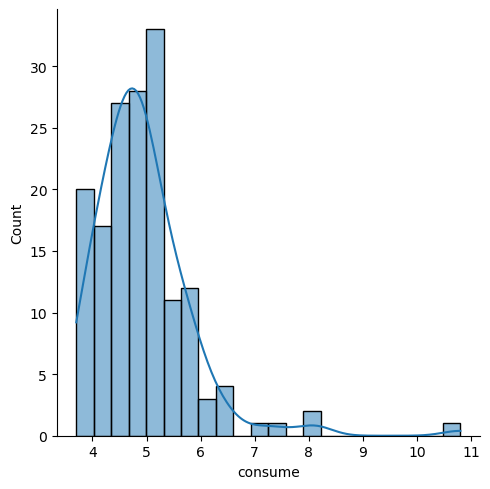

In [234]:
sns.displot(df_meas[df_meas['gas_type']=='E10']['consume'],kde=True)
plt.show()

In [301]:
df_meas[df_meas['gas_type']=='E10']['consume'].mean()

4.931250000000001

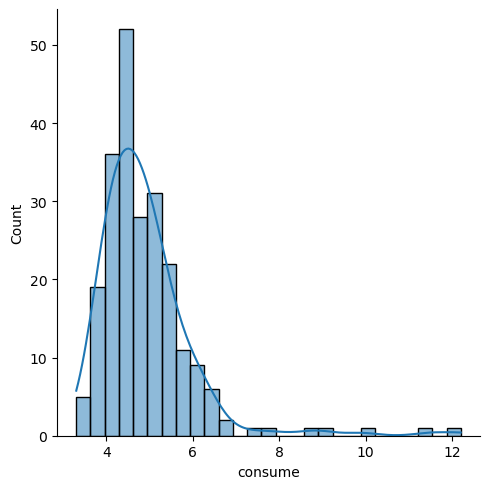

In [235]:
sns.displot(df_meas[df_meas['gas_type']=='SP98']['consume'],kde=True)
plt.show()

In [302]:
df_meas[df_meas['gas_type']=='SP98']['consume'].mean()

4.899122807017543

As we see below, there is higher fuel consumption in E10 than SP98 if the AC is kept on, with no sun or rain or snow.

In [308]:
df_meas[(df_meas['gas_type']=='E10') & (df_meas['rain']==0) & (df_meas['AC']==1) & (df_meas['sun']==0) & (df_meas['snow']==0)]['consume'].mean()

5.0

In [307]:
df_meas[(df_meas['gas_type']=='SP98') & (df_meas['rain']==0) & (df_meas['AC']==1) & (df_meas['sun']==0) & (df_meas['snow']==0)]['consume'].mean()

4.666666666666667

Interestingly, there is a higher fuel consumption in cars using SP98 instead of E10 with rain and AC on.

In [315]:
df_meas[(df_meas['gas_type']=='E10') & (df_meas['rain']==1) & (df_meas['AC']==1) & (df_meas['sun']==0) & (df_meas['snow']==0)]['consume'].mean()

5.300000000000001

In [316]:
df_meas[(df_meas['gas_type']=='SP98') & (df_meas['rain']==1) & (df_meas['AC']==1) & (df_meas['sun']==0) & (df_meas['snow']==0)]['consume'].mean()

6.575

### Function Definitions

In [238]:
def disp_corr_heatmap(X,y,verbose=False):
    corr_matrix=pd.concat([X,y],axis=1).corr(method='pearson')
    if verbose:
        display(corr_matrix)
    fig, ax = plt.subplots(figsize=(len(X.columns), len(X.columns)))
    ax = sns.heatmap(corr_matrix, annot=True)
    plt.show()

In [239]:
def transform(X,y,random_state=0,save=False,verbose=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    
    X_train_num = X_train.select_dtypes(np.number)
    X_test_num = X_test.select_dtypes(np.number)

    X_train_cat = X_train.select_dtypes(object)
    X_test_cat = X_test.select_dtypes(object)

    transformer=MinMaxScaler().fit(X_train_num)
    
    X_train_num_scaled = transformer.transform(X_train_num)
    X_train_num_scaled = pd.DataFrame(X_train_num_scaled,columns=X_train_num.columns)

    X_test_num_scaled = transformer.transform(X_test_num)
    X_test_num_scaled = pd.DataFrame(X_test_num_scaled,columns=X_test_num.columns)

    encoder = OneHotEncoder().fit(X_train_cat)
    
    X_train_cat_encoded = encoder.transform(X_train_cat).toarray()
    cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)
    X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded, columns=cols)

    X_test_cat_encoded = encoder.transform(X_test_cat).toarray()
    cols = encoder.get_feature_names_out(input_features=X_test_cat.columns)
    X_test_cat_encoded = pd.DataFrame(X_test_cat_encoded, columns=cols)

    X_train = pd.concat([X_train_num_scaled, X_train_cat_encoded], axis=1)
    X_test = pd.concat([X_test_num_scaled, X_test_cat_encoded], axis=1)
    
    if verbose:
        print("X_train_num_scaled:")
        display(X_train_num_scaled.head())
        print("X_train_num_scaled:")
        display(X_test_num_scaled.head())
        print("X_train_cat_encoded:")
        display(X_train_cat_encoded.head())
        print("X_test_cat_encoded:")
        display(X_test_cat_encoded.head())
        print("X_train:")
        display(X_train.head())
        print("X_test:")
        display(X_test.head())
        
    if save:
        pickle.dump(X_train, open('X_train.p', 'wb'))
        pickle.dump(X_test, open('X_test.p', 'wb'))
        pickle.dump(y_train, open('y_train.p', 'wb'))
        pickle.dump(y_test, open('y_test.p', 'wb'))
        pickle.dump(transformer, open('transformer.p', 'wb'))
        pickle.dump(encoder, open('encoder.p', 'wb'))
    
    return X_train, X_test, y_train, y_test, transformer, encoder

In [286]:
def produce_metrics_lm(lm,X_test,y_test,isPrint=False):
    predictions_test = lm.predict(X_test)
    r2=round(r2_score(y_test, predictions_test),2)
    mas=round(mean_absolute_error(y_test, predictions_test),2)
    mse=round(mean_squared_error(y_test,predictions_test),2)
    rmse=round(np.sqrt(mean_squared_error(y_test,predictions_test)),2)
    if isPrint:
        print("r2_score: ",r2)
        print("mean absolute error :",mas)
        print("mean square error :",mse)
        print("root mean square error :",rmse)
    else:
        return r2,mas,mse,rmse,predictions_test

In [289]:
def select_kbest_feat(X,y,k=3):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    kbest = SelectKBest(chi2, k=k).fit(X_scaled, y)
    df = pd.DataFrame(data = kbest.scores_, columns = ['score'])
    df['Column'] = numerical.columns
    selected_cols=df.sort_values(by = ['score'], ascending = False).head(k)['Column']
    return X[selected_cols]

In [294]:
def model_pipeline(X_train, X_test, y_train, y_test, model_dict):
    
    cross_val_scores = {}
    accuracy_scores = {}
    
    for model_name in model_dict.keys():
        mean_score = np.mean(cross_val_score(model_dict[model_name], X_train, y_train, cv=10))
        cross_val_scores[model_name] = round(mean_score,2)
    print("Cross Validation Scores:")
    [print(model_name," : ",cross_val_scores[model_name]) for model_name in cross_val_scores.keys()]

    for model_name in model_dict.keys():
        model_dict[model_name].fit(X_train, y_train)
        accuracy_scores[model_name] = round(model_dict[model_name].score(X_test,y_test),2)
    print("Accuracy Scores:")
    [print(model_name," : ",accuracy_scores[model_name]) for model_name in accuracy_scores.keys()]

In [295]:
def disp_score_reg(reg,X_train, X_test, y_train, y_test):
    predictions = reg.predict(X_train)
    print("Training Score:")
    print('R2 Score:', round(r2_score(y_train,predictions),2))
    print('Mean Squared Error:', round(mean_squared_error(y_train,predictions),2))
    print('Mean aboslute Error:', round(mean_absolute_error(y_train,predictions),2))
    print('Root Mean Squared Error:',round(sqrt(mean_squared_error(y_train,predictions)),2))
    print()
    print("Test Score:")
    predictions = reg.predict(X_test)
    print('R2 Score:', round(r2_score(y_test,predictions),2))
    print('Mean Squared Error:', round(mean_squared_error(y_test,predictions),2))
    print('Mean aboslute Error:', round(mean_absolute_error(y_test,predictions),2))
    print('Root Mean Squared Error:',round(sqrt(mean_squared_error(y_test,predictions)),2))

In [240]:
df_meas.head()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,snow
0,28.0,5.0,26,21.5,12,E10,0,0,0,0
1,12.0,4.2,30,21.5,13,E10,0,0,0,0
2,11.2,5.5,38,21.5,15,E10,0,0,0,0
3,12.9,3.9,36,21.5,14,E10,0,0,0,0
4,18.5,4.5,46,21.5,15,E10,0,0,0,0


### Transformation

In [241]:
X=df_meas.drop(['consume'], axis=1)
y=df_meas['consume']

In [242]:
X_train, X_test, y_train, y_test, transformer, encoder = transform(X,y,1209,False,True)

X_train_num_scaled:


,distance,speed,temp_inside,temp_outside,AC,rain,sun,snow
0,0.061516,0.305556,0.384615,0.166667,0.0,0.0,0.0,0.0
1,0.063901,0.125000,0.923077,0.972222,1.0,0.0,0.0,0.0
2,0.058655,0.236111,0.846154,0.916667,0.0,0.0,1.0,0.0
3,0.017167,0.152778,0.230769,0.222222,0.0,0.0,0.0,0.0
4,0.314258,0.708333,0.461538,0.638889,0.0,0.0,0.0,0.0


X_train_num_scaled:


,distance,speed,temp_inside,temp_outside,AC,rain,sun,snow
0,0.225560,0.388889,0.461538,0.472222,0.0,0.0,0.0,0.0
1,0.115403,0.152778,0.461538,0.888889,0.0,0.0,1.0,0.0
2,0.094421,0.375000,0.384615,0.333333,0.0,0.0,0.0,0.0
3,0.118741,0.361111,0.384615,0.305556,0.0,0.0,0.0,0.0
4,0.024320,0.291667,0.384615,0.416667,0.0,0.0,0.0,0.0


X_train_cat_encoded:


,gas_type_E10,gas_type_SP98
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0


X_test_cat_encoded:


,gas_type_E10,gas_type_SP98
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0


X_train:


,distance,speed,temp_inside,temp_outside,AC,rain,sun,snow,gas_type_E10,gas_type_SP98
0,0.061516,0.305556,0.384615,0.166667,0.0,0.0,0.0,0.0,1.0,0.0
1,0.063901,0.125000,0.923077,0.972222,1.0,0.0,0.0,0.0,0.0,1.0
2,0.058655,0.236111,0.846154,0.916667,0.0,0.0,1.0,0.0,0.0,1.0
3,0.017167,0.152778,0.230769,0.222222,0.0,0.0,0.0,0.0,0.0,1.0
4,0.314258,0.708333,0.461538,0.638889,0.0,0.0,0.0,0.0,1.0,0.0


X_test:


,distance,speed,temp_inside,temp_outside,AC,rain,sun,snow,gas_type_E10,gas_type_SP98
0,0.225560,0.388889,0.461538,0.472222,0.0,0.0,0.0,0.0,0.0,1.0
1,0.115403,0.152778,0.461538,0.888889,0.0,0.0,1.0,0.0,0.0,1.0
2,0.094421,0.375000,0.384615,0.333333,0.0,0.0,0.0,0.0,1.0,0.0
3,0.118741,0.361111,0.384615,0.305556,0.0,0.0,0.0,0.0,1.0,0.0
4,0.024320,0.291667,0.384615,0.416667,0.0,0.0,0.0,0.0,0.0,1.0


In [247]:
X_plot=pd.concat([X_train,X_test],axis=0)
X_plot=X_plot.reset_index(drop=True)
y_plot=pd.concat([y_train,y_test],axis=0)
y_plot=y_plot.reset_index(drop=True)

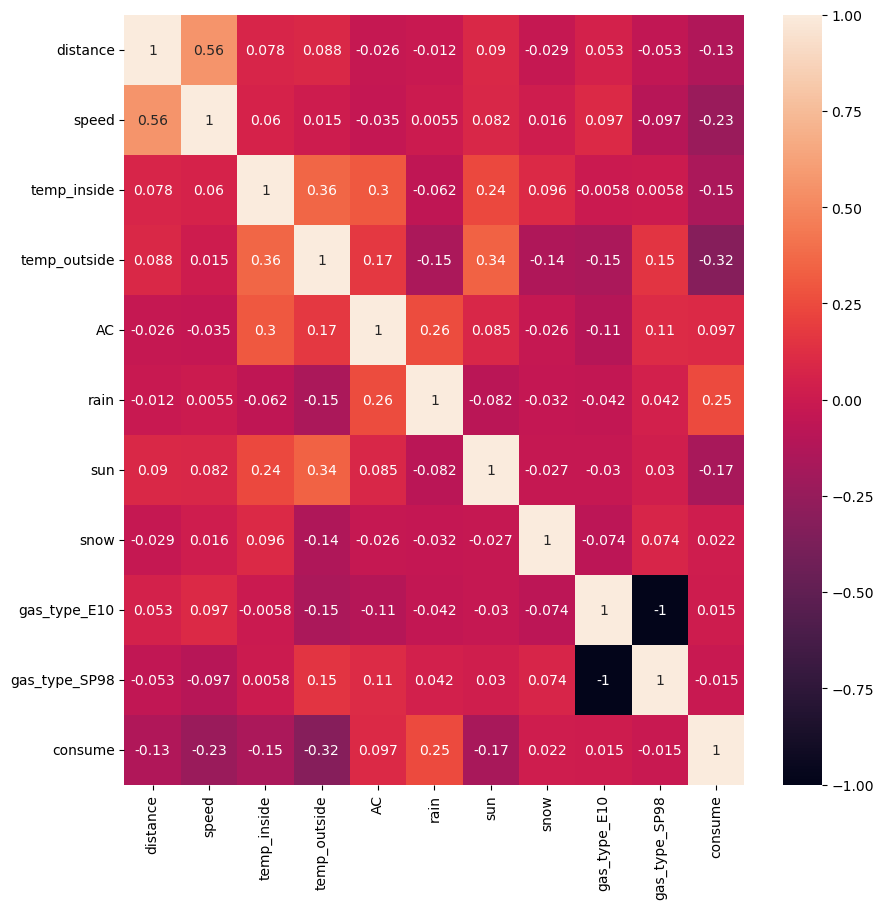

In [248]:
disp_corr_heatmap(X_plot,y_plot,verbose=False)

### #Storytelling:

As we see that the rain is one of the most driving factor (positive correlation) for fuel consumption, which could be basically turning on the heater in the car due to rain making the temperature cold outside, and temp outside (negative correlation) with fuel consumption, meaning, as the temperature grows outside, people feel a comfortable weather outside, and tend to use less of the heater in the car, which eventually uses less fuel.

### One-sided test:
+ Null hypothesis or H0: mean fuel consumption value of car during rain <= 5
+ Alternative hyp or H1: mean fuel consumption value of car during rain > 5

In [267]:
from scipy.stats import ttest_1samp
df_consume=df_meas[df_meas['rain']==1]['consume']
stat, pval = ttest_1samp(df_consume, 5)
print('stat is  ', stat)
print('pvalue for the two-tailed test is ', pval/2)

stat is   2.7621235582289505
pvalue for the two-tailed test is  0.004174167246890524


Inference - Our p-value of small value suggests us to reject the null hypothesis, which indicates that fuel is consumed more than 5L/100 km during the rainy season.

### Prediction Model

We can build up a prediction model to predict the fuel consumption of the car  based on all factors including environmental (rain, sun, snow etc.), car conditions (AC etc.) and the fuel type.

In [287]:
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [288]:
# Perform the model evaluation for Training and Test Dataset
print("Training Metrics:")
produce_metrics_lm(lm,X_train,y_train,True)
print()
print("Test Metrics:")
produce_metrics_lm(lm,X_test,y_test,True)

Training Metrics:
r2_score:  0.22
mean absolute error : 0.63
mean square error : 0.87
root mean square error : 0.93

Test Metrics:
r2_score:  0.12
mean absolute error : 0.62
mean square error : 0.79
root mean square error : 0.89


As Linear Model turns out to be a bad model, we'll try evaluating other models as below through a pipeline and using cross validation

In [292]:
model_dict={
    'Regression Tree': DecisionTreeRegressor(),
    'Linear Regression': LinearRegression(),
    'Random Forest':RandomForestRegressor()
}

In [296]:
model_pipeline(X_train, X_test, y_train, y_test,model_dict)

Cross Validation Scores:
Regression Tree  :  -0.11
Linear Regression  :  0.1
Random Forest  :  0.43
Accuracy Scores:
Regression Tree  :  0.34
Linear Regression  :  0.12
Random Forest  :  0.59


As we see the Random Forest performs the best, so we'll be using it below:

In [298]:
rfr = RandomForestRegressor(
                            n_estimators=100,
                            max_depth=50,
                            random_state=138,
                            n_jobs=-1
                            )
rfr.fit(X_train,y_train)

RandomForestRegressor(max_depth=50, n_jobs=-1, random_state=138)

In [299]:
predictions = rfr.predict(X_test)

In [300]:
disp_score_reg(rfr,X_train, X_test, y_train, y_test)

Training Score:
R2 Score: 0.93
Mean Squared Error: 0.08
Mean aboslute Error: 0.17
Root Mean Squared Error: 0.27

Test Score:
R2 Score: 0.58
Mean Squared Error: 0.38
Mean aboslute Error: 0.44
Root Mean Squared Error: 0.61


## Conclusion

+ SP98 consumes less fuel than E10.
+ Rain tends to have direct correlation to the higher fuel consumption irrespective on fuel type, as people tend to use more heater when the rain is there, as temp drops and fuel consumption is more due to load on engine.